In [5]:
import numpy as np
import glob

import torch

import matplotlib.pyplot as plt

# Important so PyTorch can load LSTM Model Weights
from Utils.PTModel.Models import VGLCLSTMModel
from Utils.Data.DataLoading import TextTileToImage

MODELNAME = "VGCLLSTM"

In [8]:
model = torch.load(f"Models/{MODELNAME}/LodeRunnerLSTM.pt")

/tmp/ipykernel_9751/2661572964.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"Models/{MODELNAME}/lstmModel1VGLC.pt")


Random Start Point: 87
Input shape: (608, 96)
target shape: (608, 96)
column shape: (608, 96, 256)
Input shape: (608, 96, 1)
target shape: (608, 96, 1)
column shape: (608, 96, 256)
input size: torch.Size([96, 1])
target size: torch.Size([96, 1])
column size: torch.Size([96, 256])
Running Model
next col size: (96, 9)
next col size: (96,)
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Part Level Image Shape: (3, 32)
input size: torch.Size([96, 1])
target size: torch.Size([96, 1])
column size: torch.Size([96, 256])
Running Model
next col size: (96, 9)
next col size: (96,)
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Part Level Image Shape: (3, 32)
input size: torch.Size([96, 1])
target size: torch.Size

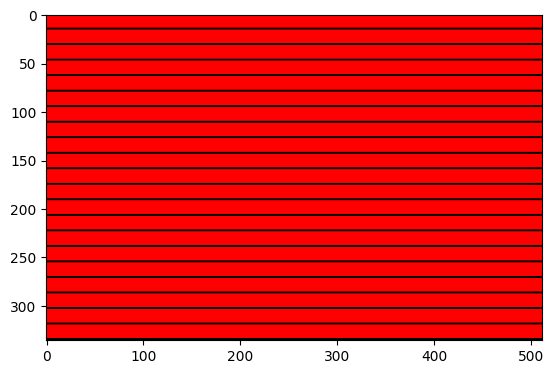

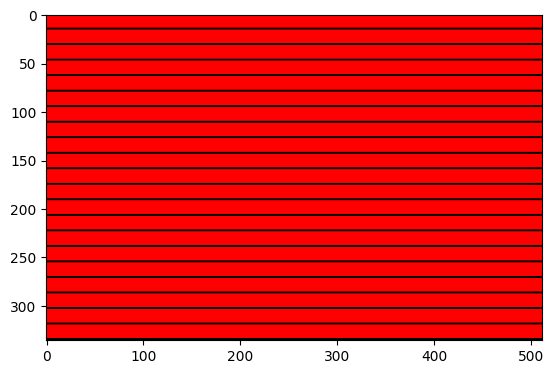

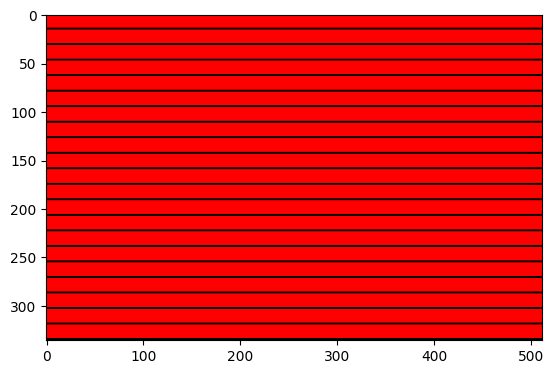

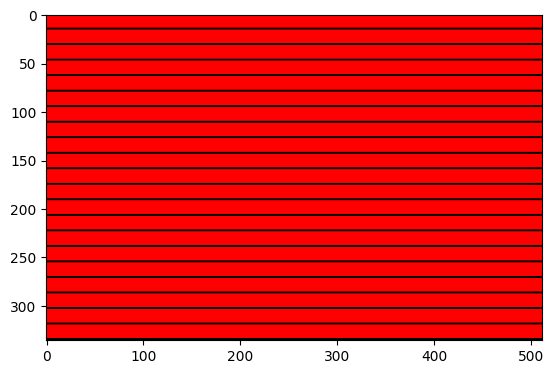

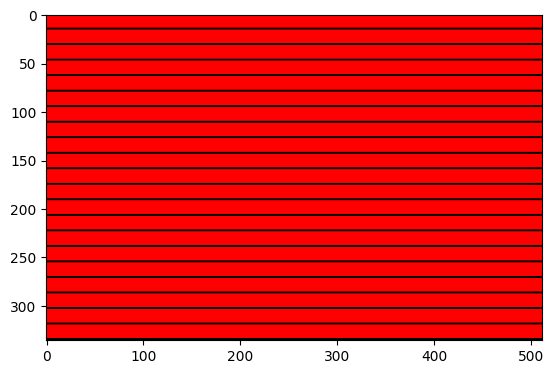

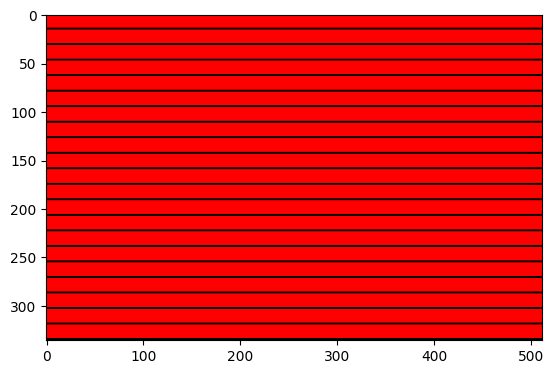

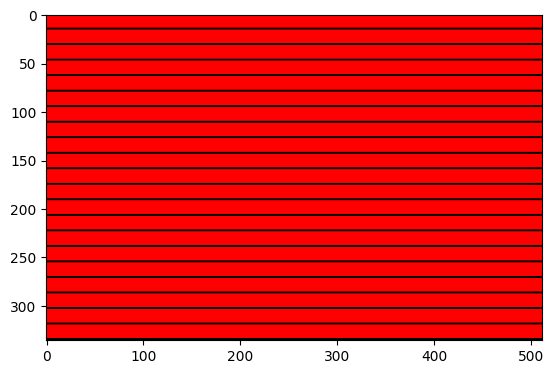

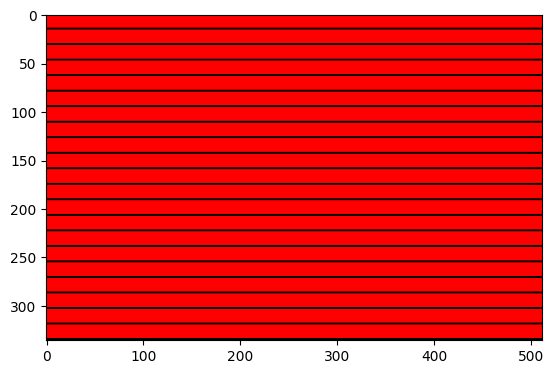

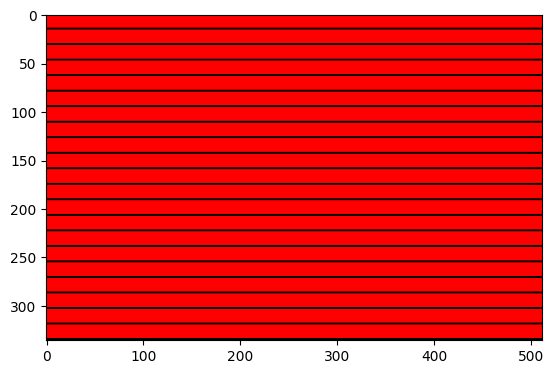

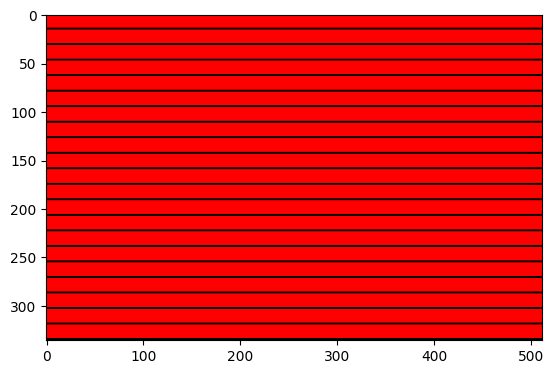

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lrStringLevelPaths = sorted(glob.glob("../data/vglc/Lode Runner/Processed/Level*.txt"))

rowLength = 32
numOfRows = 22

columnRefArray = np.array([np.arange(0, 32) for i in range(numOfRows+5)]).flatten()

tiles = {
    "B" : 0,
    "b" : 1,
    "@" : 2,
    "." : 3,
    "-" : 4,
    "#" : 5,
    "G" : 6,
    "E" : 7,
    "M" : 8,
}

model.to(device)
model.eval()

padSize = rowLength * 3 # lode runner row length * 3 as paper uses previous 3 rows for lstm
N = padSize

NLevels = 10

tilesIdx = [ "B", "b", "@", ".", "-", "#", "G", "E", "M" ]

np.random.seed(1000)
randStartPoint = np.random.randint(0, len(lrStringLevelPaths)-NLevels)
print(f"Random Start Point: {randStartPoint}")

for i, levelStringPath in enumerate(lrStringLevelPaths[randStartPoint:randStartPoint+NLevels]):

    input = []
    column = []
    target = []

    with open(levelStringPath, "r") as f:
        levelString = np.array([list(line[:-1]) for line in f.readlines()]).flatten()
        levelString = np.array([tiles[tileChar] for tileChar in levelString])

    for j in range(len(levelString) - N):

        padLength = (N - j) if j < N else 0
        RowCutOff = 0 if j <= N else RowCutOff+1

        dataI = np.concatenate((np.zeros(shape=(padLength)), levelString[RowCutOff:j]), axis=0)

        dataT = levelString[j:j+N]

        levelIdx = np.concatenate((np.zeros(shape=(padLength)), columnRefArray[RowCutOff:j]), axis=0)
        dataC = np.zeros(shape=(N, 256))
        for t in range(N): dataC[t][int(levelIdx[t])] = 1

        column.append(dataC)
        input.append(dataI)
        target.append(dataT)

    input = np.array(input)
    target = np.array(target)
    column = np.array(column)

    print(f"Input shape: {input.shape}")
    print(f"target shape: {target.shape}")
    print(f"column shape: {column.shape}")

    input = input.reshape(input.shape[0], input.shape[1], 1)
    target = target.reshape(target.shape[0], target.shape[1], 1)

    print(f"Input shape: {input.shape}")
    print(f"target shape: {target.shape}")
    print(f"column shape: {column.shape}")

    levelImage = np.empty(shape=((7 * 3), 32), dtype=str)

    for b in range(7):
        
        if b == 0:
            inputTensor = torch.tensor(input[b*N], dtype=torch.float32).to(device)
        else:
            inputTensor = torch.tensor(previousCol.reshape(previousCol.shape[0], 1), dtype=torch.float32).to(device)
        #input = torch.tensor(input[-1], dtype=torch.float32).to(device)
        print(f"input size: {inputTensor.size()}")
        
        targetTensor = torch.tensor(target[b*N], dtype=torch.float32).to(device)
        #target = torch.tensor(target[-1], dtype=torch.float32).to(device)
        print(f"target size: {targetTensor.size()}")
        
        columnTensor = torch.tensor(column[b*N], dtype=torch.float32).to(device)
        #column = torch.tensor(column[-1], dtype=torch.float32).to(device)
        print(f"column size: {columnTensor.size()}")

        print("Running Model")

        nextCol = model(inputTensor, targetTensor, columnTensor)
        nextCol = nextCol.cpu().detach().numpy()
        print(f"next col size: {nextCol.shape}")
        nextCol = np.argmax(nextCol, axis=1)
        print(f"next col size: {nextCol.shape}")
        #nextCol = nextCol[:, :78].reshape(6, 13, nextCol.shape[0]).transpose(1, 0, 2)

        # this reshape line is specific to bobble bubble as the level is in column wise order and only contains half the level needing to be mirrored
        # Make this compatible with lode runner
        # nextCol = nextCol.reshape(6, 13, nextCol.shape[1]).transpose(1, 0, 2)

        previousCol = nextCol
        nextCol = nextCol.reshape(3, 32)

        partLevelImage = np.zeros(shape=(nextCol.shape[0], nextCol.shape[1]), dtype=str)

        for t, row in enumerate(nextCol):
            for j, embedding in enumerate(row):
                print(embedding)
                partLevelImage[t, j] = tilesIdx[int(embedding)]
        
        print(f"Part Level Image Shape: {partLevelImage.shape}")
        levelImage[b*3:(b+1)*3, :] = partLevelImage

    # This line is bubble bobble specific to mirror the level
    # levelImage = np.concatenate([levelImage, np.fliplr(levelImage)], axis=1)

    plt.figure()
    plt.imshow(TextTileToImage(levelImage, 16, "../data/tomData/sprites/loderunner"))